In [23]:
from pathlib import Path

def load_file(path):
    bricks = []
    with Path(path).open() as f:
        for line in f.readlines():
            p1, p2 = line.strip().split("~")
            (x1, y1, z1), (x2, y2, z2) = [int(c) for c in p1.split(",")], [int(c) for c in p2.split(",")]
            x1, x2 = sorted([x1, x2])
            y1, y2 = sorted([y1, y2])
            z1, z2 = sorted([z1, z2])
            bricks.append(((x1, y1, z1), (x2, y2, z2)))
    return bricks

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bars(bricks):
    dx = max(p2[0] for p1, p2 in bricks)
    dy = max(p2[1] for p1, p2 in bricks)
    dz = max(p2[2] for p1, p2 in bricks)
    
    # prepare some coordinates
    x, y, z = np.indices((dx+1, dy+1, dz+1))
    
    voxelarray = np.full((dx+1, dy+1, dz+1), False)
                         
    for (x1, y1, z1), (x2, y2, z2) in bricks:
        cube = (x >= x1) &  (x <= x2) & (y >= y1) & (y <= y2) & (z >= z1) & (z <= z2)
        voxelarray = voxelarray | cube
    
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(voxelarray, edgecolor='k')
    
    plt.show()

In [25]:
bricks = load_file("22_test.txt")
bricks

[((1, 0, 1), (1, 2, 1)),
 ((0, 0, 2), (2, 0, 2)),
 ((0, 2, 3), (2, 2, 3)),
 ((0, 0, 4), (0, 2, 4)),
 ((2, 0, 5), (2, 2, 5)),
 ((0, 1, 6), (2, 1, 6)),
 ((1, 1, 8), (1, 1, 9))]

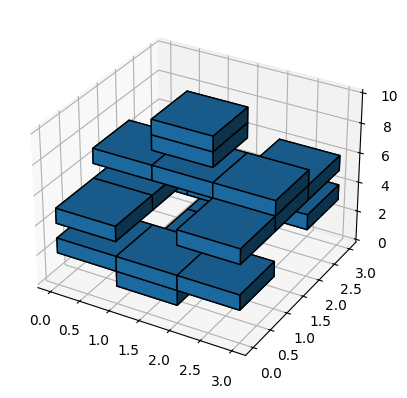

In [26]:
plot_bars(bricks)

In [27]:
def simulate(bricks):
    order = sorted(bricks, key=lambda x: x[0][2])
    placed =  [((0, 0, 0), (1000, 1000, 0))]
    moved = 0
    for (tx, ty, tz), (bx, by, bz) in order:
        ptr = len(placed) - 1
        has_moved = False
        while ptr is not None:
            (tcx, tcy, tcz), (bcx, bcy, bcz) = placed[ptr]
            if tx > bcx or ty > bcy or bx < tcx or by < tcy:
                ptr -= 1
            else:
                has_moved = bcz + 1 != tz
                placed.append(((tx, ty, bcz + 1), (bx, by, bcz + bz - tz + 1)))
                placed.sort(key=lambda x: x[1][2])
                ptr = None
        if has_moved:
            moved += 1
    placed.pop(0)
    return placed, moved

In [28]:
bricks = load_file("22_test.txt")
placed, n_moved = simulate(bricks)
placed, n_moved

([((1, 0, 1), (1, 2, 1)),
  ((0, 0, 2), (2, 0, 2)),
  ((0, 2, 2), (2, 2, 2)),
  ((0, 0, 3), (0, 2, 3)),
  ((2, 0, 3), (2, 2, 3)),
  ((0, 1, 4), (2, 1, 4)),
  ((1, 1, 5), (1, 1, 6))],
 5)

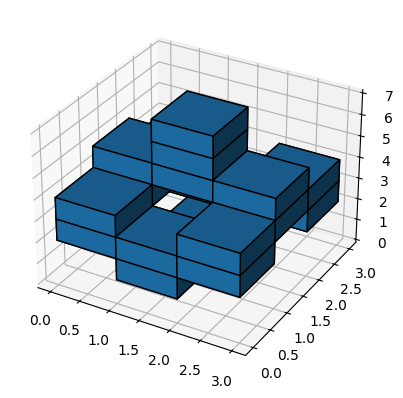

In [29]:
plot_bars(placed)

In [30]:
from collections import defaultdict
from copy import deepcopy

def connected(bricks):
    surfaces = defaultdict(list)
    for i, ((tx, ty, tz), (bx, by, bz)) in enumerate(bricks):
        surfaces[tz].append(i)
    supports = {}
    supported = defaultdict(list)
    for surface in sorted(surfaces.keys()):
        for bid in surfaces[surface]:
            supports[bid] = []
            (tx, ty, tz), (bx, by, bz) = bricks[bid]
            if bz+1 in surfaces:
                for cbid in surfaces[bz+1]:
                    (tcx, tcy, tcz), (bcx, bcy, bcz) = bricks[cbid]
                    if not (tx > bcx or ty > bcy or bx < tcx or by < tcy):
                        supports[bid].append(cbid)
                        supported[cbid].append(bid)
    return supports, supported


def degrading(placed):
    supports, supported = connected(placed)
    res = 0
    for i in range(len(placed)):
        if len(supports[i]) == 0:
            res += 1
            continue
        for bid in supports[i]:
            if len(supported[bid]) > 1:
                continue
            else:
                break
        else:
            res += 1
    return res

def check_falls(placed):
    res = 0

    for to_remove in placed:
        others = deepcopy(placed)
        others.remove(to_remove)
        _, falls = simulate(others)
        res += falls

    return res

In [31]:
bricks = load_file("22_input.txt")
placed, n_moved = simulate(bricks)
degrading(placed)  # 403

403

In [32]:
check_falls(placed)  # 70189

70189